In [ ]:
[Table of Contents](./table_of_contents.ipynb)

# One Dimensional Kalman Filters

In [2]:
using Plots
gr()

Plots.GRBackend()

Now that we understand the discrete Bayes filter and Gaussians we are prepared to implement a Kalman filter. We will do this exactly as we did the discrete Bayes filter - rather than starting with equations we will develop the code step by step based on reasoning about the problem. 

"One dimensional" means that the filter only tracks one state variable, such as position on the x-axis. In subsequent chapters we will learn a more general multidimensional form of the filter that can track many state variables simultaneously, such as position, velocity, and acceleration. Recall that we used velocity in the g-h filter to get better estimates than by tracking position alone. The same is true for the Kalman filter.

So why not just jump into the multidimensional form of the filter? To be honest, the math is difficult, and my intuitive approach to developing the filter starts to break down. This math obscures the rather simple principles that allow the Kalman filter to work.

So, in this chapter we learn how to use Gaussians to implement a Bayesian filter. That's all the Kalman filter is - a Bayesian filter that uses Gaussians. In the next chapter we will switch to a multidimensional form and the full power of the Kalman filter will be unleashed!

## Problem Description

As in the **Discrete Bayes Filter** chapter we will be tracking a moving object in a long hallway at work. Assume that in our latest hackathon someone created an RFID tracker that provides a reasonably accurate position of the dog. The sensor returns the distance of the dog from the left end of the hallway in meters. So, 23.4 would mean the dog is 23.4 meters from the left end of the hallway.

The sensor is not perfect. A reading of 23.4 could correspond to the dog being at 23.7, or 23.0. However, it is very unlikely to correspond to a position of 47.6. Testing during the hackathon confirmed this result - the sensor is 'reasonably' accurate, and while it had errors, the errors are small. Furthermore, the errors seemed to be evenly distributed on both sides of the true position; a position of 23 m would equally likely be measured as 22.9 or 23.1. Perhaps we can model this with a Gaussian.

We predict that the dog is moving. This prediction is not perfect. Sometimes our prediction will overshoot, sometimes it will undershoot. We are more likely to undershoot or overshoot by a little than a lot. Perhaps we can also model this with a Gaussian.

## Beliefs as Gaussians

We can express our belief in the dog's position with a Gaussian. Say we believe that our dog is at 10 meters, and the variance in that belief is 1 m$^2$, or $\mathcal{N}(10,\, 1)$. A plot of the pdf follows:

In [89]:
using Statistics
using Distributions: Normal
# For formatted print statements
using Printf

LoadError: ArgumentError: Package Interact not found in current path:
- Run `import Pkg; Pkg.add("Interact")` to install the Interact package.


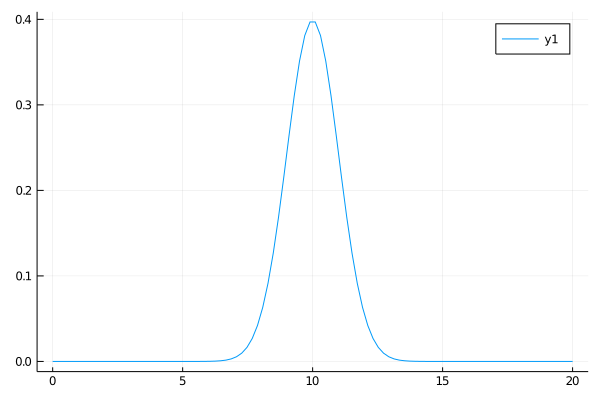

In [40]:
# \scrN<tab> = Normal(μ,σ)
𝒩 = Normal(10,1)

# Lets create a function that makes plotting distributions easier
function plotdist(dist::Distribution, xrange)
    xs = range(xrange[1],xrange[2],length=100)
    return plot(xs, pdf(dist, xs))
end

function plotdist!(dist::Distribution, xrange)
    xs = range(xrange[1],xrange[2],length=100)
    return plot!(xs, pdf(dist, xs))
end
plotdist(𝒩,[0,20])

This plot depicts our uncertainty about the dog's position. It represents a fairly inexact belief. While we believe that it is most likely that the dog is at 10 m, any position from 9 m to 11 m or so are quite likely as well. Assume the dog is standing still, and we query the sensor again. This time it returns 10.2 m. Can we use this additional information to improve our estimate?

Intuition suggests we can. Consider: if we read the sensor 500 times and each time it returned a value between 8 and 12, all centered around 10, we should be very confident that the dog is near 10. Of course, a different interpretation is possible. Perhaps our dog was randomly wandering back and forth in a way that exactly emulated random draws from a normal distribution. But that seems extremely unlikely - I've never seen a dog do that. Let's look at 500 draws from $\mathcal N(10, 1)$:

Mean of readings is 9.923

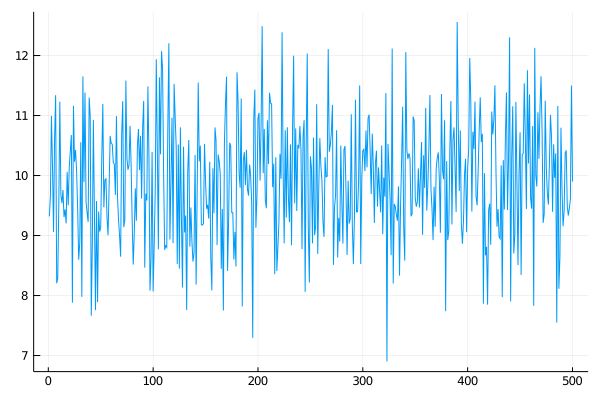

In [34]:
xs = range(1,500,length=500)
ys = randn(500) .+ 10
@printf "Mean of readings is %.3f" mean(ys)
plot(xs, ys, leg=false)

Eyeballing this confirms our intuition - no dog moves like this. However, noisy sensor data certainly looks this way.  The computed mean of the readings is almost exactly 10. Assuming the dog is standing still, we say the dog is at position 10 with a variance of 1.

## Tracking with Gaussian Probabilities

The discrete Bayes filter used a histogram of probabilities to track the dog. Each bin in the histogram represents a position, and the value is the probability of the dog being in that position.

Tracking was performed with a cycle of predictions and updates. We used the equations 

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

to compute the new probability distributions. Recall that $\bar{\mathbf x}$ is the *prior*, $\mathcal L$ is the *likelihood* of a measurement given the prior $\bar{\mathbf x}$, $f_{\mathbf x}(\bullet)$ is the *process model*, and $\ast$ denotes *convolution*. $\mathbf x$ is bold to denote that it is a histogram of numbers, or a vector.

This method works, but led to histograms that implied the dog could be in multiple places at once. Also, the computations are very slow for large problems.

Can we replace $\mathbf x$, the histogram, with a Gaussian $\mathcal N(x, \sigma^2)$? Absolutely! We've learned how to express belief as a Gaussian. A Gaussian, which is a single number pair $\mathcal N(\mu, \sigma^2),$ can replace an entire histogram of probabilities:

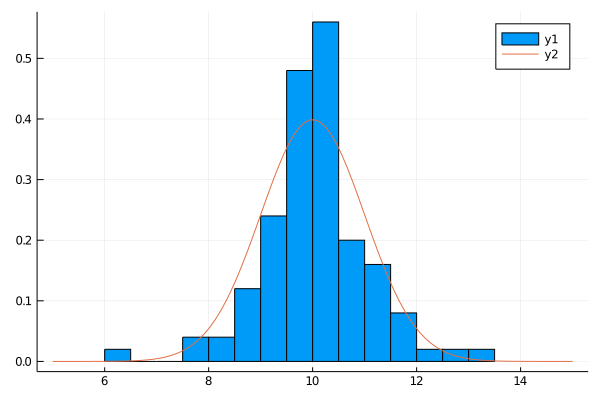

In [45]:
histogram(rand(𝒩,100),bins=15,normalized=true)
plotdist!(𝒩,[5,15])

I hope you see the power of this. We can replace hundreds to thousands of numbers with a single pair of numbers: $x = \mathcal N(\mu, \sigma^2)$. 

The tails of the Gaussian extend to infinity on both sides, so it incorporates arbitrarily many bars in the histogram. If this represents our belief in the position of the dog in the hallway, this one Gaussian covers the entire hallway (and the entire universe on that axis). We think that it is likely the dog is at 10, but he could be at 8, 14, or, with infinitesimally small probability, at 10$^{80}$. 

In this chapter we replace histograms with Gaussians:

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

where $\oplus$ and $\otimes$ is meant to express some unknown operator on Gaussians. I won't do it in the rest of the book, but the subscript indicates that $x_\mathcal{N}$ is a Gaussian. 

The discrete Bayes filter used convolution for the prediction. We showed that it used the *total probabability theorem*, computed as a sum, so maybe we can add the Gaussians. It used multiplications to incorporate the measurement into the prior, so maybe we can multiply the Gaussians. Could it be this easy:

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

This will only work if the sum and product of two Gaussians is another Gaussian. Otherwise after the first epoch $x$ would not be Gaussian, and this scheme falls apart.

## Predictions with Gaussians

We use Newton's equation of motion to compute current position based on the current velocity and previous position:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

I've dropped the notation $f_x(\bullet)$ in favor of $f_x$ to keep the equations uncluttered. 

If the dog is at 10 m, his velocity is 15 m/s, and the epoch is 2 seconds long, we have

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

We are uncertain about his current position and velocity, so this will not do. We need to express the uncertainty with a Gaussian.

Position is easy. We define $x$ as a Gaussian. If we think the dog is at 10 m, and the standard deviation of our uncertainty is 0.2 m, we get $x=\mathcal N(10, 0.2^2)$.

What about our uncertainty in his movement? We define $f_x$ as a Gaussian. If the dog's velocity is 15 m/s, the epoch is 1 second, and the standard deviation of our uncertainty is 0.7 m/s, we get $f_x = \mathcal N (15, 0.7^2)$.

The equation for the prior is 

$$\bar x = x + f_x$$

What is the sum of two Gaussians? In the last chapter I proved that:

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

This is fantastic news; the sum of two Gaussians is another Gaussian! 

The math works, but does this make intuitive sense?  Think of the physical representation of this abstract equation. We have 

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

If we add these we get:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, recall that with the `predict()` function for the discrete Bayes filter we always lost information. We don't really know where the dog is moving, so the confidence should get smaller (variance gets larger). $\mu_{f_x}^2$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty. 

Let's take advantage of the `namedtuple` class in Python's `collection` module to implement a Gaussian object. We could implement a Gaussian using a tuple, where $\mathcal N(10, 0.04)$ is implemented in Python as `g = (10., 0.04)`. We would access the mean with `g[0]` and the variance with `g[1]`.

`namedtuple` works the same as a tuple, except you provide it with a type name and field names. It's not important to understand, but I modified the `__repr__` method to display its value using the notation in this chapter. 

In [46]:
# I exclude some python specific stuff here and continue to rely on the Distributions package for distributions

In [47]:
𝒩₁ = Normal(3.4,sqrt(10.1))
𝒩₂ = Normal(4.5, 0.2)
println(𝒩₁)
println(𝒩₂)

Normal{Float64}(μ=3.4, σ=3.1780497164141406)
Normal{Float64}(μ=4.5, σ=0.2)


In [64]:
println("mean: ",𝒩₁.μ," variance: ", round(𝒩₁.σ,digits=2))

mean: 3.4 variance: 3.18


Here is our implementation of the predict function, where `pos` and `movement` are Gaussian tuples in the form ($\mu$, $\sigma^2$):

In [65]:
function predict(position, movement)
    return Normal(position.μ + movement.μ, pos.σ^2 + movement.σ^2)
end


predict (generic function with 1 method)

In [68]:
pos = Normal(10, 0.2)
move = Normal(15, .7)
predict(pos,move)

Normal{Float64}(μ=25.0, σ=0.5299999999999999)

The prior states that the dog is at 25 m with a variance of 0.53 m$^2$, which is what we computed by hand.

## Updates with Gaussians

The discrete Bayes filter encodes our belief about the position of our dog in a histogram of probabilities. The distribution is discrete and multimodal. It can express strong belief that the dog is in two positions at once, and the positions are discrete.

We are proposing that we replace the histogram with a Gaussian. The discrete Bayes filter used this code to compute the posterior:


```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

which is an implementation of the equation:

$$x = \| \mathcal L\bar x \|$$

We've just shown that we can represent the prior with a Gaussian. What about the likelihood? The likelihood is the probability of the measurement given the current state. We've learned how to represent measurements as Gaussians. For example, maybe our sensor states that the dog is at 23 m, with a standard deviation of 0.4 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (23, 0.16)$.

Both the likelihood and prior are modeled with Gaussians. Can we multiply Gaussians? Is the product of two Gaussians another Gaussian?

Yes to the former, and almost to the latter! In the last chapter I proved that the product of two Gaussians is proportional to another Gausian. 

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

We can immediately infer several things. If we normalize the result, the product is another Gaussian. If one Gaussian is the likelihood, and the second is the prior, then the mean is a scaled sum of the prior and the measurement. The variance is a combination of the variances of the prior and measurement. Finally, the variances are completely unaffected by the values of the mean!

We put this in Bayesian terms like so:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

If we implemented that in a function `gaussian_multiply()` we could implement our filter's update step as

In [72]:
function gaussian_multiply(g1::Distribution,g2::Distribution)
    μ = (var(g1)*mean(g2) + var(g2)*mean(g1))/ (var(g1) + var(g2))
    σ² = var(g1)*var(g2)/(var(g1) + var(g2))
    return Normal(μ, sqrt(σ²))
end

function update(prior::Distribution, likelihood::Distribution)
    return gaussian_multiply(likelihood, prior)
end

predicted_pos = Normal(10, .2)
measured_pos = Normal(11, .1)
estimated_pos = update(predicted_pos, measured_pos)

Normal{Float64}(μ=10.799999999999999, σ=0.0894427190999916)

Perhaps this would be clearer if we used more specific names:

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```

That is less abstract, which perhaps helps with comprehension, but it is poor coding practice. We are writing a Kalman filter that works for any problem, not just tracking dogs in a hallway, so we won't use variable names with 'dog' in them. Also, this form obscures the fact that we are multiplying the likelihood by the prior.

We have the majority of our filter implemented, but I fear this step is still a bit confusing. I've asserted that we can multiply Gaussians and that it correctly performs the update step, but why is this true? Let's take a detour and spend some time multiplying Gaussians.

### Understanding Gaussian Multiplication

Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

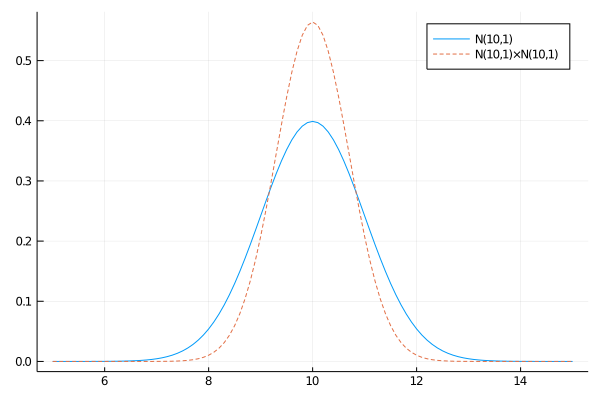

In [86]:
z = Normal(10, 1)
product = gaussian_multiply(z,z)

xs = collect(range(5,15,step=0.1))
ys = pdf(z, xs)

plot(xs, ys, label="N(10,1)")

yss = pdf(product, xs)
plot!(xs, yss, linestyle=:dash, label="N(10,1)×N(10,1)")

The result of the multiplication is taller and narrow than the original Gaussian but the mean is unchanged. Does this match your intuition?

Think of the Gaussians as two measurements. If I measure twice and get 10 meters each time, I should conclude that the length is close to 10 meters. Thus the mean should be 10. It would make no sense to conclude the length is actually 11, or 9.5. Also, I am more confident with two measurements than with one, so the variance of the result should be smaller. 

"Measure twice, cut once" is a well known saying. Gaussian multiplication is a mathematical model of this physical fact. 

I'm unlikely to get the same measurement twice in a row. Now let's plot the pdf of $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$. What do you think the result will be? Think about it, and then look at the graph.

In [92]:
#using Pkg
#Pkg.add("Interact")
using Interact

@manipulate for i in slider()

   Updating registry at `C:\Users\Bleep\.julia\registries\General`
  Resolving package versions...
  Installed JSExpr ──────────────── v0.5.2
  Installed AssetRegistry ───────── v0.1.0
  Installed Pidfile ─────────────── v1.2.0
  Installed Knockout ────────────── v0.2.4
  Installed Observables ─────────── v0.3.1
  Installed Interact ────────────── v0.10.3
  Installed WebSockets ──────────── v1.5.2
  Installed InteractBase ────────── v0.10.5
  Installed Widgets ─────────────── v0.6.2
  Installed FunctionalCollections ─ v0.5.0
  Installed CSSUtil ─────────────── v0.1.1
  Installed WebIO ───────────────── v0.8.14
Updating `C:\Users\Bleep\.julia\environments\v1.5\Project.toml`
  [c601a237] + Interact v0.10.3
Updating `C:\Users\Bleep\.julia\environments\v1.5\Manifest.toml`
  [bf4720bc] + AssetRegistry v0.1.0
  [70588ee8] + CSSUtil v0.1.1
  [de31a74c] + FunctionalCollections v0.5.0
  [c601a237] + Interact v0.10.3
  [d3863d7c] + InteractBase v0.10.5
  [97c1335a] + JSExpr v0.5.2
  [bcebb21b] +